<a href="https://colab.research.google.com/github/BrunoKrinski/fcn_colab/blob/master/fcn_exercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!rm -rf datasets runs

In [0]:
########################################################################################################################
# Libraries instalation
########################################################################################################################
!pip install -U scikit-learn
!pip install opencv-python

     |████████████████████████████████| 7.0MB 6.6MB/s 
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


In [0]:
########################################################################################################################
# Imports
########################################################################################################################
# Select Tensorflow 2.0
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import os
import cv2
import glob
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime, date
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Progbar
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, mean_absolute_error
from tensorflow.keras.layers import Input, UpSampling2D, Conv2D, Add, Activation, Conv2DTranspose, Dropout

TensorFlow 2.x selected.


In [0]:
########################################################################################################################
# Download dataset
########################################################################################################################
os.chdir('/content/')

def create_dataset_file(dataset_name):
  abspath = os.path.abspath('datasets/')
  images_path = glob.glob(dataset_name + '/images/*.jpg')
  dataset_file = open(dataset_name + '/' + dataset_name + '.txt','w')
  for image_path in images_path:
    image_path = abspath + '/' + image_path
    mask_path = image_path.replace('/images/','/masks/').replace('.jpg','.png')
    line = image_path + ' ' + mask_path + '\n'
    dataset_file.write(line) 
  dataset_file.close()

links = ['http://saliencydetection.net/duts/download/DUTS-TR.zip', 'http://saliencydetection.net/duts/download/DUTS-TE.zip']

dataset_name = 'DUTS'
datasets_path = 'datasets'

if not os.path.exists('datasets'):
  os.system('mkdir datasets')

for link in links:
  os.system('wget ' + link)

print('Extracting ' + dataset_name + ' dataset...')
os.system('unzip DUTS-TR.zip')
os.system('unzip DUTS-TE.zip')
os.system('rm DUTS-TR.zip')
os.system('rm DUTS-TE.zip')
os.system('mv DUTS-TR DUTS')
os.system('mv DUTS/DUTS-TR-Image DUTS/images')
os.system('mv DUTS/DUTS-TR-Mask DUTS/masks')
os.system('mv DUTS-TE/DUTS-TE-Image DUTS-TE/images')
os.system('mv DUTS-TE/DUTS-TE-Mask DUTS-TE/masks')

print('Creating ' + dataset_name + ' file...')
create_dataset_file('DUTS')
create_dataset_file('DUTS-TE')

print('Moving ' + dataset_name + '...')
os.system('mv DUTS datasets/')
os.system('mv DUTS-TE datasets/')

Extracting DUTS dataset...
Creating DUTS file...
Moving DUTS...


0

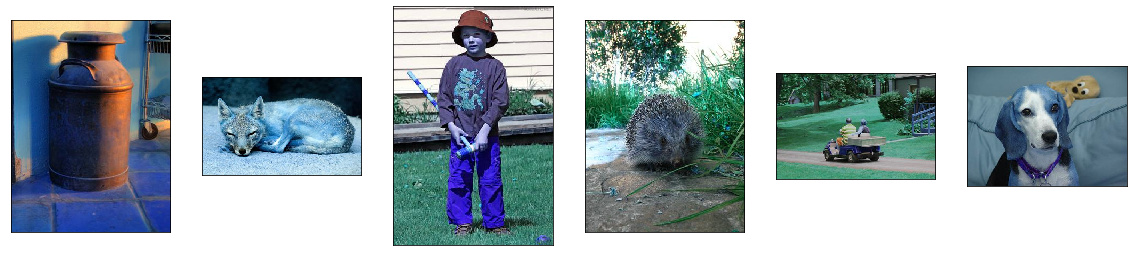

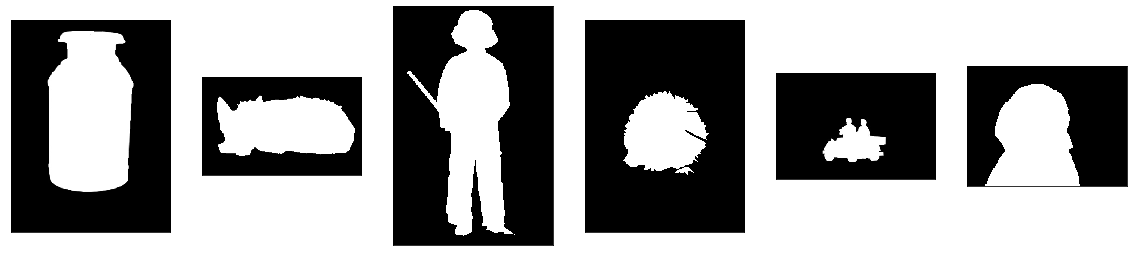

In [0]:
dataset_file = 'datasets/DUTS/DUTS.txt'

with open(dataset_file, 'r') as lines:
  paths = lines.read().splitlines()

plt.figure(figsize=(20,20))
for i in range(6):
  image_path, mask_path = paths[i].replace('\n','').split(' ')
  image = cv2.imread(image_path)
  
  plt.subplot(2, 6, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image)
plt.show()

plt.figure(figsize=(20,20))
for i in range(6):
  image_path, mask_path = paths[i].replace('\n','').split(' ')
  mask = cv2.imread(mask_path)
  plt.subplot(2, 6, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(mask)
plt.show()    

In [0]:
########################################################################################################################
# A Fold class to store dataset folds
########################################################################################################################
class Fold:
  def __init__(self, train_images, train_masks, test_images, test_masks):
    self.train_images = train_images
    self.train_masks = train_masks
    self.test_images = test_images
    self.test_masks = test_masks

########################################################################################################################
# A Dataset class to handle the dataset
########################################################################################################################
class Dataset:
  def __init__(self, dataset_name):
    self.name = dataset_name
    self.path = 'datasets/' + dataset_name
    self.file_path = self.path + '/' + dataset_name + '.txt'

    self.images = []
    self.masks = []

    dataset_file = open(self.file_path, 'r')
    for line in dataset_file:
      image, mask = line.replace('\n','').split(' ')
      self.images.append(image)
      self.masks.append(mask)
    self.size = len(self.images)
  
  # Returns the dataset without split
  def allDataset(self):
    return self.images, self.masks
  
  # Returns X_train, X_test, y_train, y_test 
  def split(self, test_size=0.1):
    return train_test_split(self.images, self.masks, shuffle=True, test_size=test_size)

In [0]:
########################################################################################################################
# Load dataset generator
########################################################################################################################
def load_image(image_path, width, height):
  image = cv2.imread(image_path)
  image = cv2.resize(image, (width, height))
  image = image/255.
  return np.expand_dims(image, axis=0)

def load_mask(mask_path, width, height):
  mask = cv2.imread(mask_path,0)
  mask = cv2.resize(mask, (width, height))
  mask = np.where(mask<127,0,1)
  mask = mask.reshape(width, height, 1)
  return np.expand_dims(mask, axis=0)

def salience_generator(images_path, masks_path, width, height):
  while True:
    for image, mask in zip(images_path, masks_path):
      x = load_image(image, width, height)
      y = load_mask(mask, width, height)
      yield x, y

In [0]:
########################################################################################################################
# Metrics Callback
########################################################################################################################
class MetricsPerEpoch(tf.keras.callbacks.Callback):
  def __init__(self, validation_data=(), logs={}):
    self.images, self.masks, self.run, self.width, self.height = validation_data
    self.fmeasure = 0
    self.mae = 0
    
  def on_epoch_end(self, epoch, logs={}):
    print('\nValidating...')
    progbar = Progbar(len(self.images))
    self.fmeasure = 0
    self.mae = 0
    for i in range(len(self.images)):
      image = cv2.imread(self.images[i])
      #print(image)
      image = cv2.resize(image, (self.width, self.height))
      image = image/255.
      image = np.expand_dims(image, axis=0)

      mask = cv2.imread(self.masks[i],0)
      mask = cv2.resize(mask, (self.width, self.height))

      mask = np.where(mask<127,0,1)  
      mask = mask.reshape(-1)
            
      index = 0.8
      mask_pred = self.model.predict(image)
      mask_pred = np.squeeze(mask_pred, axis=0)
      mask_pred = np.where(mask_pred<index,0,1)
    
      mask_pred = mask_pred.reshape(-1)
      tn, fp, fn, tp = confusion_matrix(mask,mask_pred).ravel()
      precision = (tp / (tp + fp + 1e-10))
      recall = (tp / (tp + fn + 1e-10))
      betasq = 0.3
      fmeasure = (1 + betasq) * (precision * recall) / ((betasq * precision) + recall + 1e-10)
      mae = mean_absolute_error(mask, mask_pred)
      self.mae += mae
      self.fmeasure += fmeasure
      progbar.update(i)
    progbar.update(i)
    fmeasure_str = ' - F-measure: ' + '{0:.4f}'.format(self.fmeasure*100/len(self.images)) + '%'
    mae_str = ' - MAE: ' + '{0:.4f}'.format(self.mae/len(self.images))
    print(fmeasure_str + mae_str)

In [0]:
########################################################################################################################
# Save segmentation masks Callback
########################################################################################################################
class SaveImagesOnLastEpoch(tf.keras.callbacks.Callback):
  def __init__(self, validation_data=(), logs={}):
    self.images, self.masks, self.run, self.images_path, self.width, self.height = validation_data

  def on_train_end(self, epoch, logs={}):
    print('\nSaving images...')
    progbar = Progbar(len(self.images))
    images_path = self.run + '/' + self.images_path
    os.system('mkdir ' + images_path)
    for i in range(len(self.images)):
      image = cv2.imread(self.images[i])
      image = cv2.resize(image, (self.width, self.height))
      image = image/255.
      image = np.expand_dims(image, axis=0)
      index = 0.6
      mask_pred = self.model.predict(image)
      mask_pred = np.squeeze(mask_pred)
      mask_pred = np.where(mask_pred<index,0,255)
      mask_pred = np.array(mask_pred, dtype=np.uint8)
      mask_pred_path = images_path + self.masks[i].split('/')[-1]
      cv2.imwrite(mask_pred_path, mask_pred)
      progbar.update(i)
    progbar.update(i)

In [0]:
########################################################################################################################
# Save weights Callback
########################################################################################################################
def save_weights(run_path):
  weights_path = run_path + '/weights'
  os.system('mkdir ' + weights_path)
  
  ckpt_path = weights_path + '/' + 'ckpt-{epoch:04d}.ckpt'
  
  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    verbose=1
  )
  
  return ckpt_callback, ckpt_path

![alt text](http://deeplearning.net/tutorial/_images/fcn.png)
![alt text](http://deeplearning.net/tutorial/_images/fcn_schema.png)

Reference: http://deeplearning.net/tutorial/fcn_2D_segm.html

![alt text](https://www.researchgate.net/profile/Michael_Wurm/publication/331258180/figure/fig1/AS:728763826442243@1550762244632/Architecture-of-the-FCN-VGG19-adapted-from-Long-et-al-2015-which-learns-to-combine.png)

Reference: https://www.researchgate.net/publication/331258180_Semantic_Segmentation_of_slums_in_satellite_images_using_transfer_learning_on_fully_convolutional_neural_networks

![alt text](https://miro.medium.com/max/986/1*kOThnLR8Fge_AJcHrkR3dg.gif)
![alt text](https://miro.medium.com/max/1152/1*6iT86_FgzFIY7_fEoCrM_w.png)

Reference: https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8

keras.layers.Conv2DTranspose(filters, kernel_size, strides=(1, 1), padding='valid', output_padding=None, data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)

---

keras.layers.Add()

In [0]:
########################################################################################################################
# FCN Model
########################################################################################################################
def fcn8vgg16(width=224, height=224, weights='imagenet', num_classes=1):
  
  vgg16 = VGG16(weights=weights, include_top=False, input_shape=(width, height, 3))

  for layer in vgg16.layers:
    layer.trainable = False

  layer = vgg16.get_layer('layer name').output

  '''
    build fcn8
  '''

  return fcn8

In [0]:
########################################################################################################################
# FCN Model
########################################################################################################################
def unetvgg16(width=224, height=224, weights='imagenet', num_classes=1):
  '''
    build unet
  '''
  return unet

In [0]:
########################################################################################################################
# Main
########################################################################################################################
today = date.today()
now = datetime.now().time()
now = str(now).split('.')[0]

if not os.path.exists('runs'):
  os.system('mkdir runs')

run_folder = 'runs/' + str(today) + '_' + str(now)
os.system('mkdir ' + run_folder)

model = fcn8vgg16()

images_width = 224
images_height = 224

opt = optimizers.SGD(lr=1E-2, momentum=0.9)

train_dataset = Dataset('DUTS')

images_train, images_test, masks_train, masks_test = train_dataset.split(test_size=0.1)
train_gen = salience_generator(images_train, masks_train, images_width, images_height)
val_gen = salience_generator(images_test, masks_test, images_width, images_height)

metrics_per_epoch = MetricsPerEpoch(validation_data=(images_test, masks_test, run_folder, images_width, images_height))
save_images_on_last_epoch = SaveImagesOnLastEpoch(validation_data=(images_test, masks_test, run_folder, 'images/', images_width, images_height))
ckpt_callback, ckpt_path = save_weights(run_folder)

callbacks = [metrics_per_epoch, save_images_on_last_epoch, ckpt_callback]

model.compile(loss='binary_crossentropy', optimizer=opt)
model.save(ckpt_path.format(epoch=0))
model.fit_generator(train_gen, steps_per_epoch=len(images_train), epochs=1, callbacks=callbacks)

58892288/58889256 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_____________________________